In [1]:
import numpy as np
import matplotlib.pyplot as plt
from spike_generators import GutniskyUnivariateSpikeGenerator, KaulakysUnivariateSpikeGenerator

from scipy.signal import lfilter, welch
from scipy.fft import irfft

In [2]:
# Pink noise generation

## TODO: Author / Source ??

def minmax(x):
    """min max normalizes the given array"""
    return (x - np.min(x))/(np.max(x)-np.min(x))

def generate_pink_noise(num_traces = 100, num_samples = 4999):
    """
    Modulates a generated gausian white noise trace to create pink noise.
    
    Parameters
    ----------
    num_traces : int, optional
        number of noise traces to create (first dimension), by default 100
    num_samples : int, optional
        length of the trace (second dimension), by default 4999
    Returns
    -------
    np.array
        noise trace
    """    
    B = [0.049922035, -0.095993537, 0.050612699, -0.004408786]  #The coefficient A, B determines a filter that converts white noise to 1/f spectrum. 
    A = [1, -2.494956002,   2.017265875,  -0.522189400]         #You can use this function to check the frequency response of the filter, which should give you a 1/f amplitude response.

    invfn = np.zeros((num_traces,num_samples))
    for i in np.arange(0,num_traces):
        wn = np.random.normal(loc=1, scale=0.5, size=num_samples+2000)
        invfn[i,:] = wn[2000:]
        invfn[i,:] = minmax(lfilter(B, A, wn)[2000:])+0.5                # Filtering white noise to create a close approximation of '1/f' Noise
                                                                            # The filtered signal is pink noise with 0 mean. 
                                                                            # The minmax function normalizes the signal to have values between [0,1].
                                                                            # Adding 0.5 to it makes it positive and have mean 1, since firing rate cannot be negative
    return invfn

In [3]:
def generate_cov_with_oof_psd():

    # Generate 1/f psd empirically
    pink_noise = generate_pink_noise(1, 2000)
    emp_freq, emp_psd = welch(pink_noise)
    emp_psd = emp_psd.flatten()

    # Compute empirical autocovariance
    emp_autocov = irfft(emp_psd, 300)
    emp_autocov = emp_autocov[:len(emp_autocov)//2]
    
    # Generate 1/f psd theoretically
    th_psd = 1 / np.linspace(0, 0.5, 100)
    th_psd[0] = 400 # Random number to replace infinity with

    th_autocov = irfft(th_psd, 300)
    th_autocov = th_autocov[:len(th_autocov)//2]

    _, ax = plt.subplots(2, 2, figsize = (12, 8))
    ax[0, 0].plot(emp_freq, emp_psd)
    ax[0, 0].set_title("Empirical PSD")

    ax[0, 1].plot(emp_autocov)
    ax[0, 1].set_title("Empirical Autocovariance")

    ax[1, 0].plot(th_psd)
    ax[1, 0].set_title("Theoretical PSD")

    ax[1, 1].plot(emp_autocov)
    ax[1, 1].set_title("Theoretical Autocovariance")

    plt.show()

    return emp_autocov, th_autocov

/var/folders/gs/_z8_31zd6xz_w20ny978y50w0000gn/T/ipykernel_99012/546087550.py:13: RuntimeWarning: divide by zero encountered in divide
  th_psd = 1 / np.linspace(0, 0.5, 100)


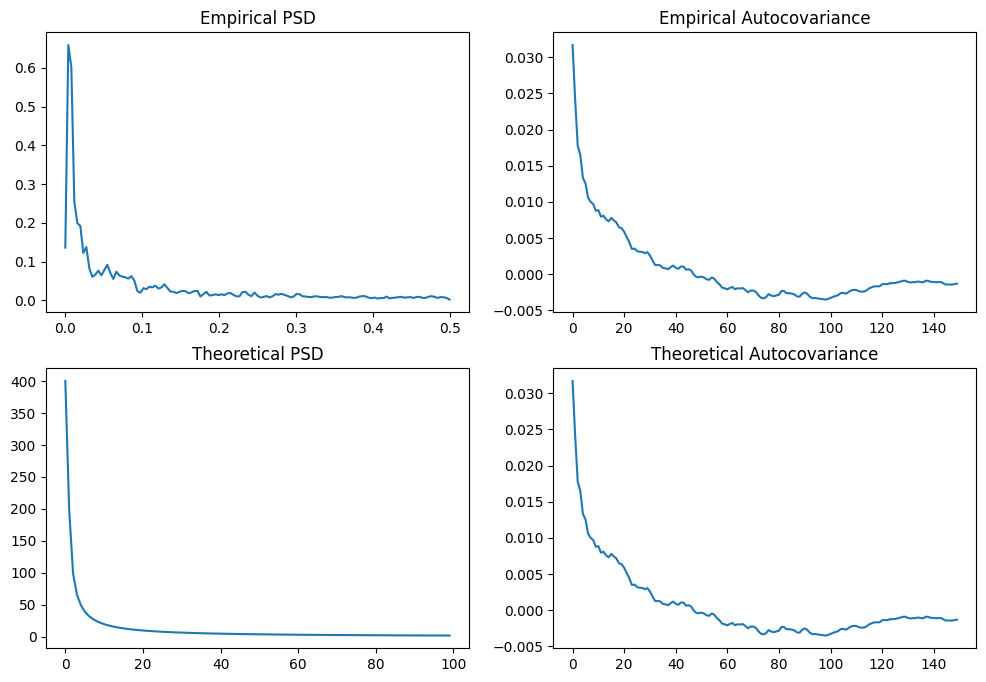

In [4]:
emp_autocov, th_autocov = generate_cov_with_oof_psd()

In [5]:
mean_spiking_rate = 0.3

#### Gutnisky

Accepts a neuron's mean spiking rate and a vector of autocovariances between spikes $[1.0, Cov(y_t, y_{t-1}), \ldots, Cov(y_t, y_{t-k})]$. Outputs the generated spike train and the respective AR($k$) process it was obtained with.

In [6]:
# Assumption: R(0) = 1
emp_autocov = np.insert(emp_autocov, 0, 1)
th_autocov = np.insert(th_autocov, 0, 1)

In [7]:
# Use AR(3)

gutnisky = GutniskyUnivariateSpikeGenerator()

emp_train, emp_y = gutnisky.get_spike_train(r = mean_spiking_rate, spike_train_autocov = emp_autocov[:3], 
                                            len_spike_train = 5000)

th_train, th_y = gutnisky.get_spike_train(r = mean_spiking_rate, spike_train_autocov = th_autocov[:3], 
                                          len_spike_train = 5000)

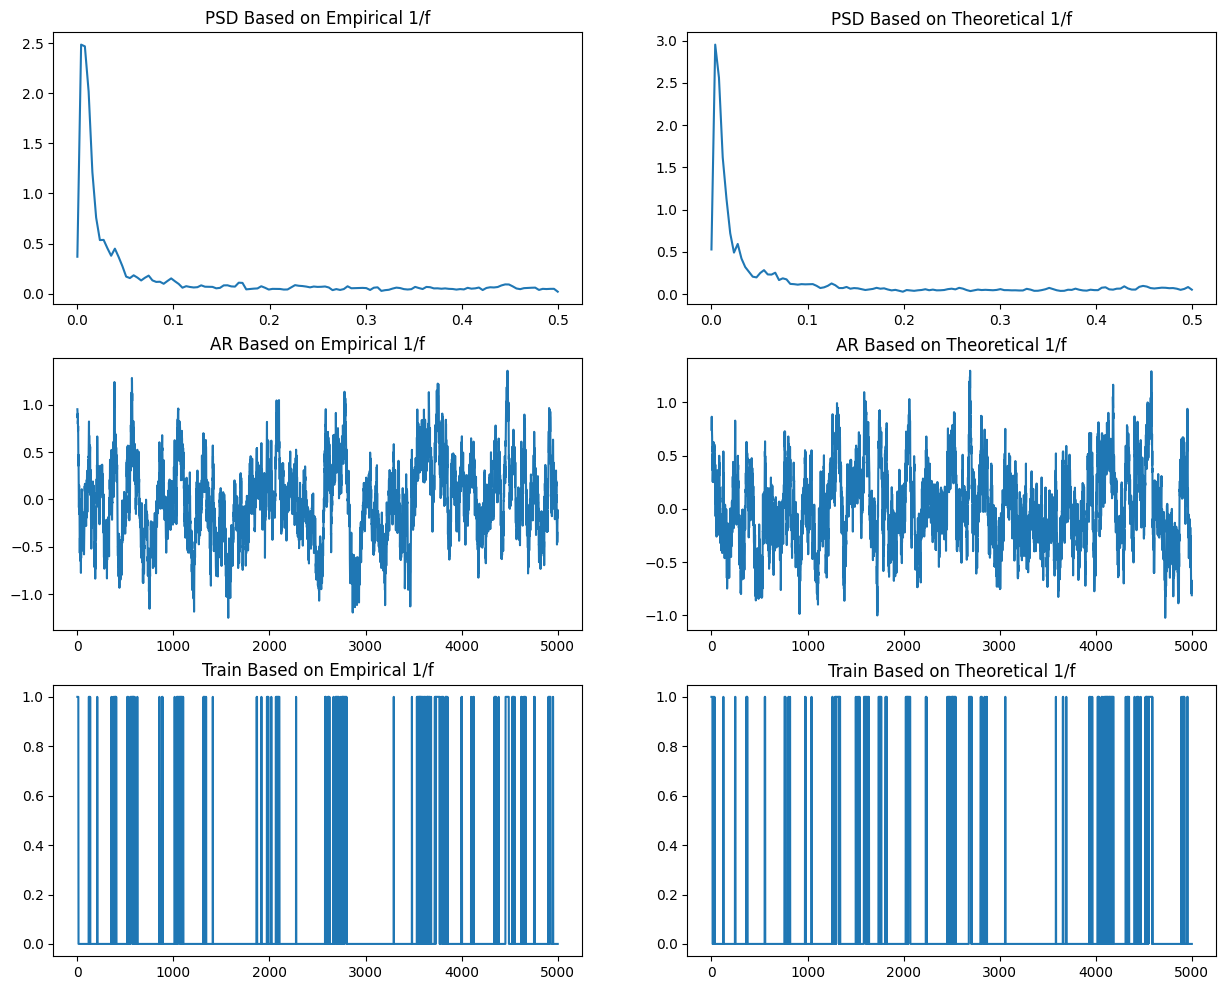

In [8]:
_, ax = plt.subplots(3, 2, figsize = (15, 12))

emp_freq, emp_psd = welch(emp_train)
th_freq, th_psd = welch(th_train)

ax[0, 0].plot(emp_freq, emp_psd)
ax[0, 0].set_title("PSD Based on Empirical 1/f")
ax[0, 1].plot(th_freq, th_psd)
ax[0, 1].set_title("PSD Based on Theoretical 1/f")

ax[1, 0].plot(emp_y)
ax[1, 0].set_title("AR Based on Empirical 1/f")
ax[1, 1].plot(th_y)
ax[1, 1].set_title("AR Based on Theoretical 1/f")

ax[2, 0].plot(emp_train)
ax[2, 0].set_title("Train Based on Empirical 1/f")
ax[2, 1].plot(th_train)
ax[2, 1].set_title("Train Based on Theoretical 1/f");

#### Kaulakys

Accepts a neuron's mean spiking rate and length of the spike train. Outputs **interspike times** which have $1/f$ PSD.

**Note:** it is a heavily randomized algorithm, so it needs to be re-run until the desired PSD is produced.

In [78]:
mean_spiking_rate = 1
sp_gen_kaulakys = KaulakysUnivariateSpikeGenerator()
train, interevent_times = sp_gen_kaulakys.get_spike_train(1, 1000, 0.01)

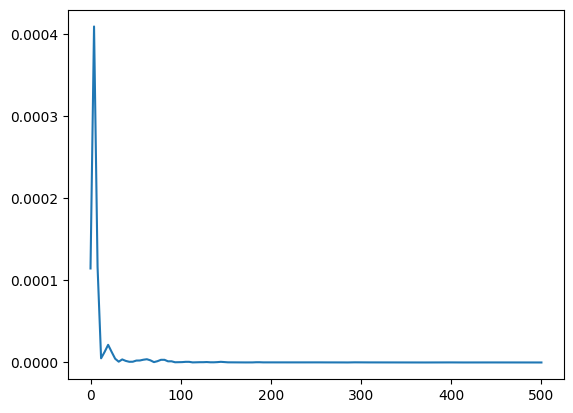

In [80]:
freq, psd = welch(interevent_times, fs = 1000)
plt.plot(freq, psd)